#**Heart Rate Prediction and Forecasting through Time Series Analysis**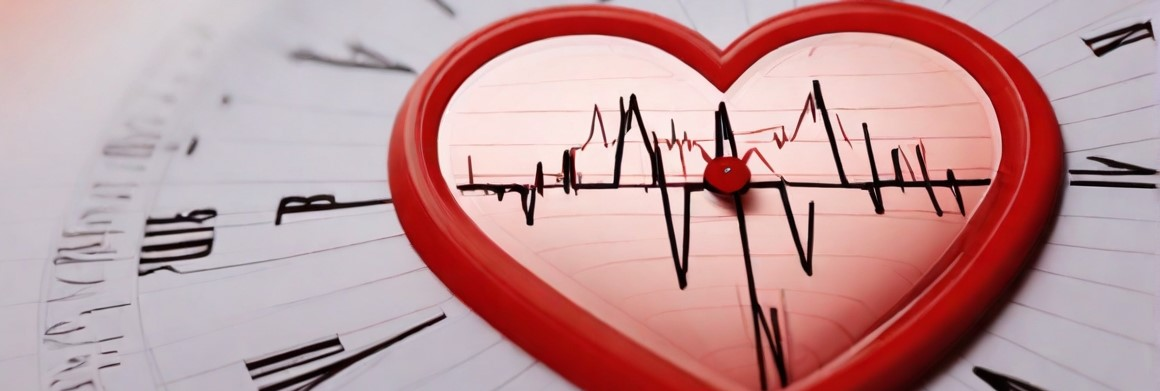

*Made by Syed Ali Hamza Shah
(ID: 22102368)*

*MSc(AI) Birmingham City University*

# Introduction

Heart rate fluctuations pose potential health risks, from stroke to cardiac arrest. Timely monitoring is crucial for early detection. Leveraging AI and stream processing, accurate predictions become feasible.

Utilized a four-hour patient heart rate time series to construct a robust model predicting the next 20 minutes.

In this notebook we have used two models ARIMA and SARIMA for prediction of the heart rate and conclusively provided comparison of each model.

# Importing Libraries

In [1]:
# Numerical and Data Manipulation
import numpy as np
import pandas as pd
# Plotting and Visualization
import matplotlib.pyplot as plt
# Statistical Modeling
import statsmodels.api as sm
# Iteration and Combinatorial Tools
import itertools
# Model Evaluation
from sklearn.metrics import mean_squared_error
# Time Series Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Logging
from logging import critical


# Data load

In [2]:
# load the data set
df = pd.read_csv('/content/PT_Train.csv', parse_dates=['Timestamp (GMT)'])
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139,41,NaN,NaN
1,2015-08-17 15:10:00,144,40,92.0,140.0
2,2015-08-17 15:11:00,140,42,89.0,144.0
3,2015-08-17 15:12:00,138,45,93.0,141.0
4,2015-08-17 15:13:00,133,42,94.0,134.0


# Exploratory Data Analysis (EDA)

It invloves data cleaning, handling missing values, outlier treatment, potential data transformations, and splitting data for training and testing. The goal is to prepare the heart rate data for accurate modeling.

##Data Visualization

In [3]:
#summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Timestamp (GMT)             226 non-null    datetime64[ns]
 1   Lifetouch Heart Rate        226 non-null    int64         
 2   Lifetouch Respiration Rate  226 non-null    int64         
 3   Oximeter SpO2               191 non-null    float64       
 4   Oximeter Pulse              191 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.0 KB


In [4]:
#Data types of each column in the DataFrame
df.dtypes

Timestamp (GMT)               datetime64[ns]
Lifetouch Heart Rate                   int64
Lifetouch Respiration Rate             int64
Oximeter SpO2                        float64
Oximeter Pulse                       float64
dtype: object

In [5]:
#Descriptive statistics for the DataFrame
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


In [6]:
# DataFrame with a subset of columns, focusing on the specific columns of interest for further analysis or modeling.
df = df[['Timestamp (GMT)', 'Lifetouch Heart Rate']]

In [7]:
#The first few rows of the DataFrame
df.head()

,Timestamp (GMT),Lifetouch Heart Rate
0,2015-08-17 15:09:00,139
1,2015-08-17 15:10:00,144
2,2015-08-17 15:11:00,140
3,2015-08-17 15:12:00,138
4,2015-08-17 15:13:00,133


<ipython-input-8-befbfb0cb616>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


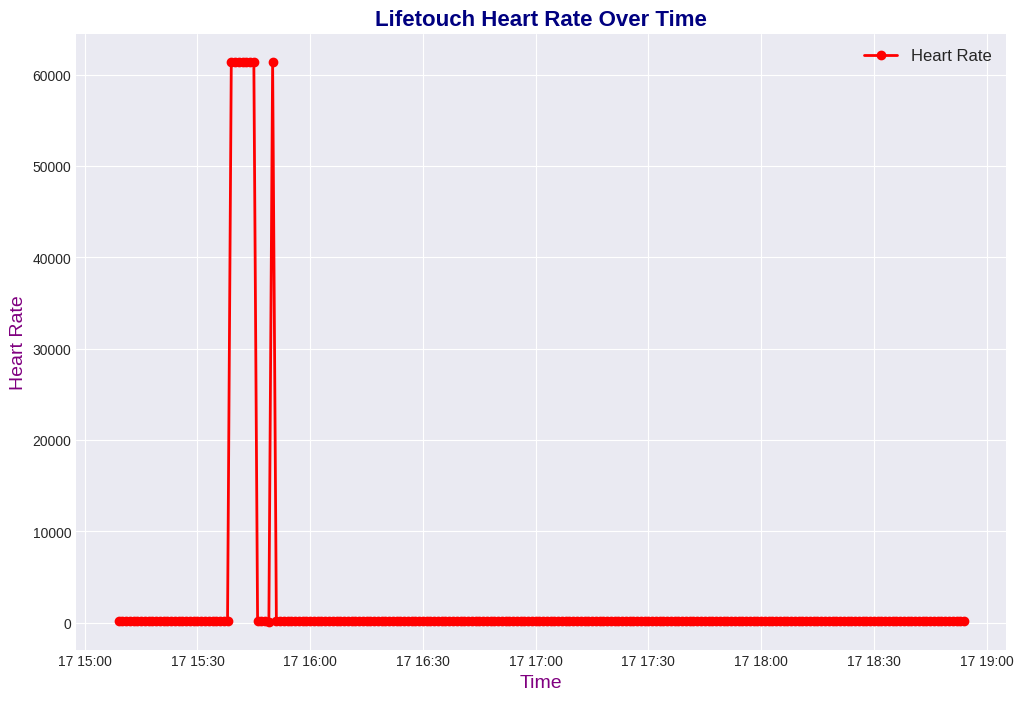

In [8]:
# Plot the Lifetouch Heart Rate over time
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(df['Timestamp (GMT)'], df['Lifetouch Heart Rate'], label='Heart Rate', color='red', linewidth=2, marker='o', markersize=6)
plt.title('Lifetouch Heart Rate Over Time', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Time', fontsize=14, color='purple')
plt.ylabel('Heart Rate', fontsize=14, color='purple')
plt.legend(fontsize=12)

plt.show()


##Data Cleaning

We notice some outliers in the data, let us check if those outliers are much, so that we can know the next step to do. We can drop them or fill them with something else, first making those outliers a NAN value

In [9]:
# Replace values in 'Lifetouch Heart Rate' column with NaN if greater than 50000
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(lambda x: np.nan if x>50000 else x)

###Handling Missing Values

Enhancing heart rate dataset by addressing missing values, treating outliers, and ensuring suitability for accurate modeling.

In [10]:
# Checking the count of missing values in each column
df.isnull().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    8
dtype: int64

In [11]:
# Selecting rows where column has missing values
df[df['Lifetouch Heart Rate'].isnull()]

,Timestamp (GMT),Lifetouch Heart Rate
30,2015-08-17 15:39:00,NaN
31,2015-08-17 15:40:00,NaN
32,2015-08-17 15:41:00,NaN
33,2015-08-17 15:42:00,NaN
34,2015-08-17 15:43:00,NaN
35,2015-08-17 15:44:00,NaN
36,2015-08-17 15:45:00,NaN
41,2015-08-17 15:50:00,NaN


Backward fill(bfill): Filling missing values with the next available observation in the sequence.

In [12]:
# Fill missing values in 'Lifetouch Heart Rate' column using backward fill (bfill)
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].fillna(method='bfill')

Set the style and plot Lifetouch Heart Rate over time

<ipython-input-13-9591ef650803>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


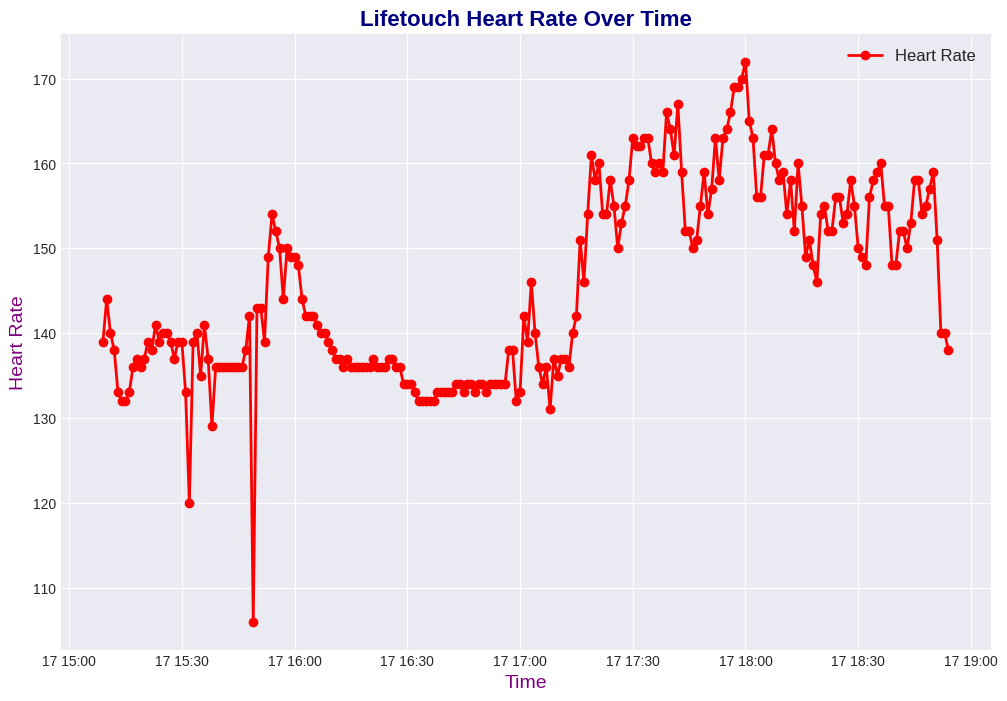

In [13]:
plt.style.use('seaborn-darkgrid')
# Plot the Lifetouch Heart Rate over time
plt.figure(figsize=(12, 8))
plt.plot(df['Timestamp (GMT)'], df['Lifetouch Heart Rate'], label='Heart Rate', color='red', linewidth=2, marker='o', markersize=6)
plt.title('Lifetouch Heart Rate Over Time', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Time', fontsize=14, color='purple')
plt.ylabel('Heart Rate', fontsize=14, color='purple')
plt.legend(fontsize=12)

plt.show()


##Data Stationarity Check and Transformation

Two functions are created to check the stationarity of the time series data. The result indicates whether the series is stationary or not.

In [14]:
# check stationarity of the series using KPSS test
def check_stationarity_KPPS(series):
  # KPSS test
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [15]:
# check stationarity of the series using ADF test
def check_stationarity_ADF(series):
    # ADF test
    result = sm.tsa.adfuller(series)
    # Print the ADF test results
    print('ADF Test - Test Statistic: %f' % result[0])
    print('ADF Test - p value: %f' % result[1])
    print('ADF Test - Critical Values: %s' % result[4])
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary \n')

In [16]:
# Check stationarity using KPSS test on Lifetouch Heart Rate
check_stationarity_KPPS(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



<ipython-input-14-4c47b876f606>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


In [17]:
# Check stationarity using ADF test on Lifetouch Heart Rate
check_stationarity_ADF(df['Lifetouch Heart Rate'])

ADF Test - Test Statistic: -1.972008
ADF Test - p value: 0.298980
ADF Test - Critical Values: {'1%': -3.460018927623594, '5%': -2.8745897386146817, '10%': -2.57372514086348}
Result: The series is not stationary 



###**Log Transformation of Data**

Our data exhibits non-stationary behavior, indicating the need for transformation to achieve stationarity before proceeding with modeling.

In [18]:
# Apply log transformation to Lifetouch Heart Rate and create a new column 'Log Heart Rate'
df['Log Heart Rate'] = np.log(df['Lifetouch Heart Rate'])

In [19]:
#Checking the dataframe for Log Heart Rate
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate
0,2015-08-17 15:09:00,139.0,4.934474
1,2015-08-17 15:10:00,144.0,4.969813
2,2015-08-17 15:11:00,140.0,4.941642
3,2015-08-17 15:12:00,138.0,4.927254
4,2015-08-17 15:13:00,133.0,4.890349


<ipython-input-20-d31230249d88>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


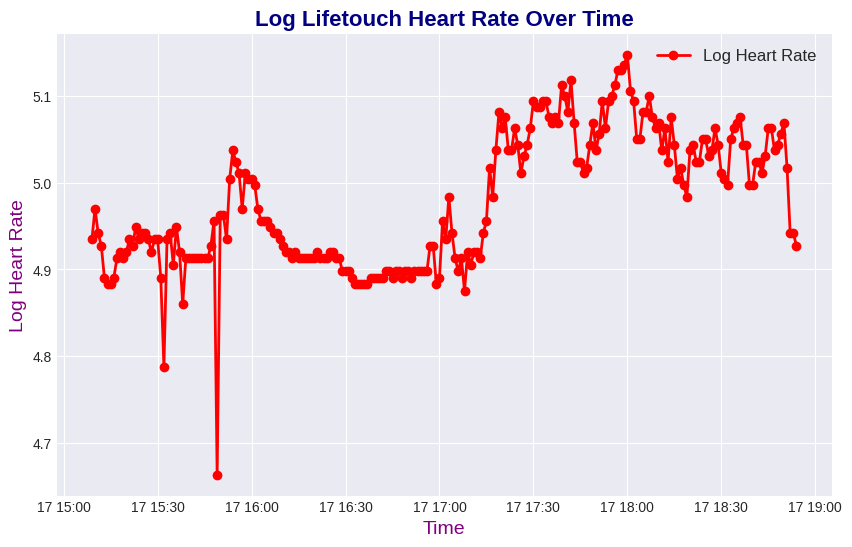

In [20]:
# Plot time series after log transformation
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp (GMT)'], df['Log Heart Rate'], label='Log Heart Rate', color='red', linewidth=2, marker='o', markersize=6)
plt.title('Log Lifetouch Heart Rate Over Time', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Time', fontsize=14, color='purple')
plt.ylabel('Log Heart Rate',fontsize=14, color='purple')
plt.legend(fontsize=12)
plt.show()


In [21]:
# Check if the log data is stationary
print('Stationarity check by KPPS test: \n')
check_stationarity_KPPS(df['Log Heart Rate'])
print('Stationarity check by ADF test: \n')
check_stationarity_ADF(df['Log Heart Rate'])


Stationarity check by KPPS test: 

p value: 0.01
Result: The series is not stationary 

Stationarity check by ADF test: 

ADF Test - Test Statistic: -2.016204
ADF Test - p value: 0.279514
ADF Test - Critical Values: {'1%': -3.460018927623594, '5%': -2.8745897386146817, '10%': -2.57372514086348}
Result: The series is not stationary 



<ipython-input-14-4c47b876f606>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


###**Deseasonalize Transformation of Data**

Removes recurring patterns (seasonality) in time-series data, making it easier to model and enhancing prediction accuracy.

In [22]:
# Deseasonalize Heart Rate by differencing the Log Heart Rate
df['Deseasonalize Heart Rate'] = df[['Log Heart Rate']].diff(axis=0)

<ipython-input-23-9542e68c71eb>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


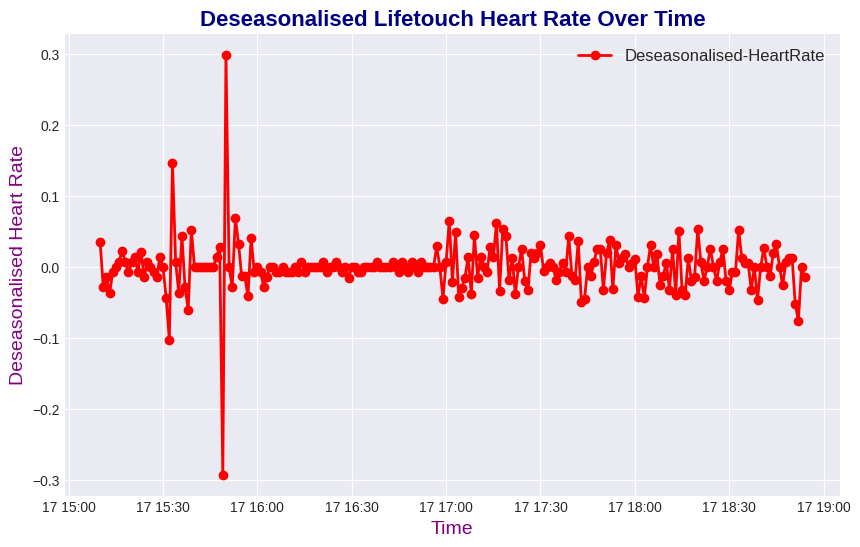

In [23]:
# Plot Deseasonalized Lifetouch Heart Rate over time
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp (GMT)'], df['Deseasonalize Heart Rate'], label='Deseasonalised-HeartRate', color='red', linewidth=2, marker='o', markersize=6)
plt.title('Deseasonalised Lifetouch Heart Rate Over Time', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Time', fontsize=14, color='purple')
plt.ylabel('Deseasonalised Heart Rate',fontsize=14, color='purple')
plt.legend(fontsize=12)
plt.show()

In [24]:
# Check if the Deseason data is stationary
print('Stationarity check by KPPS test: \n')
check_stationarity_KPPS(df['Deseasonalize Heart Rate'].dropna())
print('Stationarity check by ADF test: \n')
check_stationarity_ADF(df['Deseasonalize Heart Rate'].dropna())


Stationarity check by KPPS test: 

p value: 0.1
Result: The series is stationary 

Stationarity check by ADF test: 

ADF Test - Test Statistic: -15.774554
ADF Test - p value: 0.000000
ADF Test - Critical Values: {'1%': -3.460018927623594, '5%': -2.8745897386146817, '10%': -2.57372514086348}
Result: The series is stationary 



<ipython-input-14-4c47b876f606>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


# Model Prepration

Preparing the heart rate dataset by splitting into train(80%) and evaluation sets(20%).

The data is split in ascending order based on the timestamp.The advantage of having data in ascending order, especially when dealing with time series data, is that it aligns with the natural progression of time. In time series analysis, the order of observations matters, and having data sorted in ascending order based on the timestamp or time index allows for a clear understanding of the chronological sequence of events.

In [25]:
# Split the data into train and test set using 80% of the data for training, remaining 20% for evaluation.
train_size = int(len(df) * 0.8)

train_series = df[:train_size]
eval_series = df[train_size:]

In [26]:
# Display the last few rows of the training series
train_series.tail()

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate,Deseasonalize Heart Rate
175,2015-08-17 18:04:00,156.0,5.049856,0.000000
176,2015-08-17 18:05:00,161.0,5.081404,0.031548
177,2015-08-17 18:06:00,161.0,5.081404,0.000000
178,2015-08-17 18:07:00,164.0,5.099866,0.018462
179,2015-08-17 18:08:00,160.0,5.075174,-0.024693


In [27]:
# Display the last few rows of the evaluation series
eval_series.tail()

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate,Deseasonalize Heart Rate
221,2015-08-17 18:50:00,159.0,5.068904,0.012658
222,2015-08-17 18:51:00,151.0,5.017280,-0.051624
223,2015-08-17 18:52:00,140.0,4.941642,-0.075637
224,2015-08-17 18:53:00,140.0,4.941642,0.000000
225,2015-08-17 18:54:00,138.0,4.927254,-0.014389


In [28]:
# Display the shapes of the training and evaluation series
train_series.shape, eval_series.shape

((180, 4), (46, 4))

#Model Training

During the training phase, the model is trained on data from 2015-08-17, specifically from 15:09:00 to 18:08:00. Subsequently, the models predictive performance will be assessed for the time span between 18:09:00 and 18:54:00.

Employed two models, ARIMA and SARIMA, to construct a robust time series model for predicting the subsequent twenty observations (minutes) of heart rate data (Lifetouch Heart Rate).

##ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that combines autoregression, differencing, and moving averages to make predictions based on historical data patterns.

In [29]:
# We will use the ARIMA model to model the series
from statsmodels.tsa.arima.model import ARIMA

In [30]:
# Set the 'Timestamp (GMT)' column as the index for the DataFrame
df.set_index('Timestamp (GMT)', inplace=True)

In [31]:
# Set the 'Timestamp (GMT)' column as the index for the training and evaluation series
train_series.set_index('Timestamp (GMT)', inplace=True)
eval_series.set_index('Timestamp (GMT)', inplace=True)

In [32]:
# Drop rows with NaN values in the 'Deseasonalize Heart Rate' column for the training series
train_series = train_series.dropna(subset=['Deseasonalize Heart Rate'])

In [33]:
# Tune the ARIMA model
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
# Iterate over all possible combinations of parameters
for param in pdq:
    try:
        model = ARIMA(df['Lifetouch Heart Rate'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq} with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dat

Best ARIMA parameters: (0, 1, 4) with AIC: 1340.0262982797858


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# Instantiate and fit the ARIMA model
model = ARIMA(df['Lifetouch Heart Rate'], order=(1,0,0))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [35]:
# Display the summary of ARIMA model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                   ARIMA(1, 0, 0)   Log Likelihood                -683.768
Date:                  Thu, 29 Feb 2024   AIC                           1373.536
Time:                          11:07:09   BIC                           1383.798
Sample:                      08-17-2015   HQIC                          1377.677
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.0519      3.557     40.781      0.000     138.081     152.023
ar.L1          0.8946      0.022     40.186      0.000       0.851       0.938
sigma2        24.6812      0.861     28.678      0.000      22.994      26.368
===================================================================================
Ljung-Box (L1) (Q):                  16.10   Jarque-Bera (JB):              3682.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###Model Prediction

In [36]:
# Define the start and end date for predictions.
pred_start_date=eval_series.index[0]
pred_end_date=eval_series.index[-1]

In [37]:
#Looking the time evaluation set start.
pred_start_date

Timestamp('2015-08-17 18:09:00')

In [38]:
#Looking the time evaluation set end.
pred_end_date

Timestamp('2015-08-17 18:54:00')

In [39]:
# Generate predictions using the ARIMA model
prediction_ARIMA = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [40]:
# Predicted values using the ARIMA model
prediction_ARIMA

2015-08-17 18:09:00    158.425113
2015-08-17 18:10:00    156.635827
2015-08-17 18:11:00    157.530470
2015-08-17 18:12:00    153.057254
2015-08-17 18:13:00    156.635827
2015-08-17 18:14:00    151.267968
2015-08-17 18:15:00    158.425113
2015-08-17 18:16:00    153.951897
2015-08-17 18:17:00    148.584038
2015-08-17 18:18:00    150.373325
2015-08-17 18:19:00    147.689395
2015-08-17 18:20:00    145.900109
2015-08-17 18:21:00    153.057254
2015-08-17 18:22:00    153.951897
2015-08-17 18:23:00    151.267968
2015-08-17 18:24:00    151.267968
2015-08-17 18:25:00    154.846540
2015-08-17 18:26:00    154.846540
2015-08-17 18:27:00    152.162611
2015-08-17 18:28:00    153.057254
2015-08-17 18:29:00    156.635827
2015-08-17 18:30:00    153.951897
2015-08-17 18:31:00    149.478681
2015-08-17 18:32:00    148.584038
2015-08-17 18:33:00    147.689395
2015-08-17 18:34:00    154.846540
2015-08-17 18:35:00    156.635827
2015-08-17 18:36:00    157.530470
2015-08-17 18:37:00    158.425113
2015-08-17 18:

### Model Evaluation

In [41]:
# Assign the predicted values to the evaluation series
eval_series['Predicted_ARIMA'] = prediction_ARIMA

<ipython-input-41-165a87b9ee0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_series['Predicted_ARIMA'] = prediction_ARIMA


In [42]:
# Display the first few rows of the evaluation series
eval_series.head()

,Lifetouch Heart Rate,Log Heart Rate,Deseasonalize Heart Rate,Predicted_ARIMA
Timestamp (GMT),,,,
2015-08-17 18:09:00,158.0,5.062595,-0.012579,158.425113
2015-08-17 18:10:00,159.0,5.068904,0.006309,156.635827
2015-08-17 18:11:00,154.0,5.036953,-0.031952,157.530470
2015-08-17 18:12:00,158.0,5.062595,0.025642,153.057254
2015-08-17 18:13:00,152.0,5.023881,-0.038715,156.635827


####Mean Square Error (MSE)

MSE measures the average squared difference between observed and predicted values, indicating model accuracy.

In [43]:
# Calculate the mean squared error between actual and predicted values
mean_squared_error(eval_series['Lifetouch Heart Rate'], eval_series['Predicted_ARIMA'])

15.960938661450028

####Square Root Mean Square Error (RMSE)

RMSE shows the mean square error(mse) square root for better interpretability in the original unit.

In [44]:
# Calculate the root mean squared error
mse = mean_squared_error(eval_series['Lifetouch Heart Rate'], eval_series['Predicted_ARIMA'])
rmse = np.sqrt(mse)

print(f"Root mean square error is: {rmse}")

Root mean square error is: 3.995114348983021


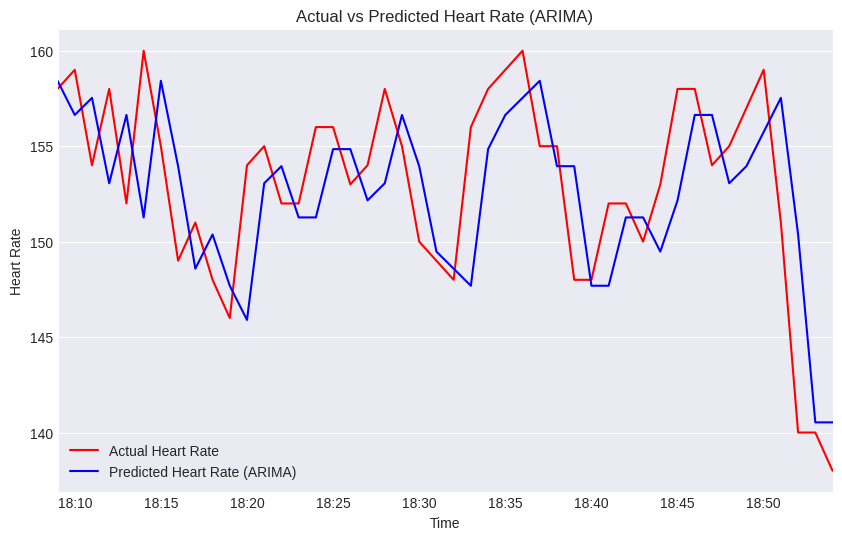

In [45]:
# Plotting actual and predicted heart rates
eval_series[['Lifetouch Heart Rate', 'Predicted_ARIMA']].plot(color=['red', 'blue'], figsize=(10, 6))
plt.title('Actual vs Predicted Heart Rate (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend(["Actual Heart Rate", "Predicted Heart Rate (ARIMA)"])
plt.show()

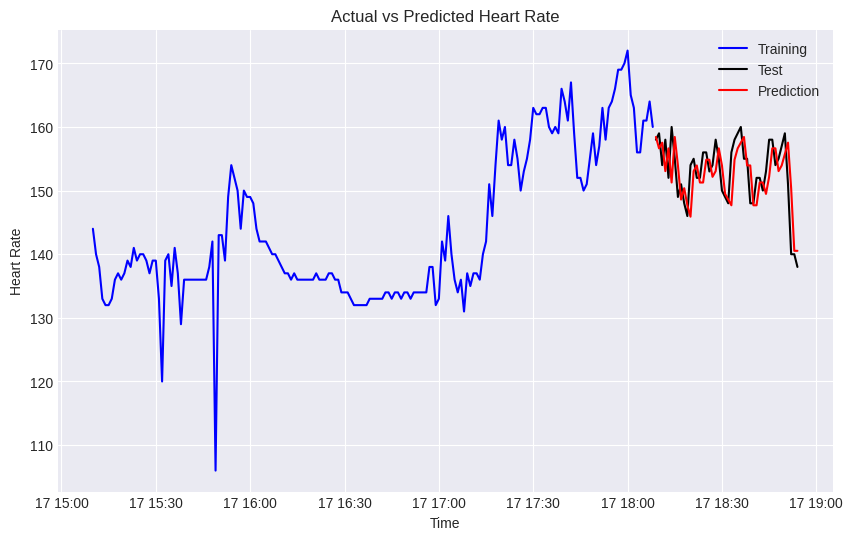

In [46]:
# Plotting training, test, and predicted heart rates
plt.figure(figsize=(10, 6))
plt.plot(train_series['Lifetouch Heart Rate'], color='blue', label='Training')
plt.plot(eval_series['Lifetouch Heart Rate'], color='black', label='Test')
plt.plot(eval_series['Predicted_ARIMA'], color='red', label='Prediction')
plt.legend()
plt.title('Actual vs Predicted Heart Rate')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.show()

### Model Forcasting

The Mean Squared Error (MSE) and RMSE of our model is satisfactory, especially considering the absence of identified seasonality.

Proceeding to forecast the next 20 minutes.

In [47]:
# Generating forecasts for the next 20 steps
forecasts = model_fit.get_forecast(steps=20)

In [51]:
# Assign the forecasted values to a variable
forecast_values = forecasts.predicted_mean

In [52]:
forecast_values

2015-08-17 18:55:00    138.742964
2015-08-17 18:56:00    139.407651
2015-08-17 18:57:00    140.002310
2015-08-17 18:58:00    140.534316
2015-08-17 18:59:00    141.010273
2015-08-17 19:00:00    141.436084
2015-08-17 19:01:00    141.817033
2015-08-17 19:02:00    142.157846
2015-08-17 19:03:00    142.462752
2015-08-17 19:04:00    142.735534
2015-08-17 19:05:00    142.979577
2015-08-17 19:06:00    143.197908
2015-08-17 19:07:00    143.393237
2015-08-17 19:08:00    143.567986
2015-08-17 19:09:00    143.724325
2015-08-17 19:10:00    143.864192
2015-08-17 19:11:00    143.989323
2015-08-17 19:12:00    144.101270
2015-08-17 19:13:00    144.201423
2015-08-17 19:14:00    144.291025
Freq: T, Name: predicted_mean, dtype: float64

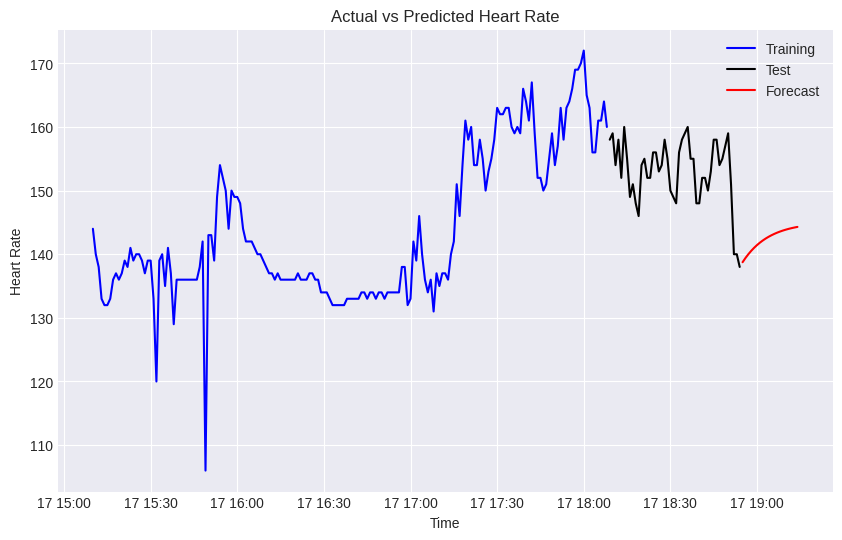

In [53]:
# Plot observations, predictions, and forecasts
plt.figure(figsize=(10, 6))
plt.plot(train_series['Lifetouch Heart Rate'], color='blue', label='Training')
plt.plot(eval_series['Lifetouch Heart Rate'], color='black', label='Test')
plt.plot(forecast_values, color='red', label='Forecast')
plt.legend()
plt.title('Actual vs Predicted Heart Rate')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.show()

## SARIMA Model

 A forecasting model that considers seasonality in time series data. It combines autoregressive, differencing, and moving average components to predict patterns with recurring seasonal trends.

In [ ]:
# Define the range for p, d, q, P, D, Q, and S
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_params = None

# Iterate over all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df['Lifetouch Heart Rate'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except Exception as e:
            continue

print(f'Best SARIMA parameters: {best_params} with AIC: {best_aic}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dat

Best SARIMA parameters: ((0, 2, 2), (0, 2, 2, 12)) with AIC: 1062.3285613872347


### Model Prediction

In [ ]:
# Generate predictions using SARIMA model
prediction_SRIMA = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
# Display the predictions using SARIMA model
prediction_SRIMA

2015-08-17 18:09:00    159.807326
2015-08-17 18:10:00    157.895606
2015-08-17 18:11:00    158.865947
2015-08-17 18:12:00    153.840114
2015-08-17 18:13:00    158.098678
2015-08-17 18:14:00    151.957562
2015-08-17 18:15:00    160.097563
2015-08-17 18:16:00    154.897770
2015-08-17 18:17:00    148.756524
2015-08-17 18:18:00    150.900241
2015-08-17 18:19:00    147.815108
2015-08-17 18:20:00    146.019462
2015-08-17 18:21:00    153.956373
2015-08-17 18:22:00    154.868715
2015-08-17 18:23:00    152.044728
2015-08-17 18:24:00    151.783657
2015-08-17 18:25:00    156.071202
2015-08-17 18:26:00    155.665058
2015-08-17 18:27:00    153.044069
2015-08-17 18:28:00    154.072539
2015-08-17 18:29:00    157.837942
2015-08-17 18:30:00    154.984918
2015-08-17 18:31:00    149.959160
2015-08-17 18:32:00    148.669656
2015-08-17 18:33:00    147.873275
2015-08-17 18:34:00    155.984203
2015-08-17 18:35:00    157.895922
2015-08-17 18:36:00    158.779208
2015-08-17 18:37:00    159.894566
2015-08-17 18:

In [ ]:
# Fit SARIMAX model
model = SARIMAX(df['Lifetouch Heart Rate'], order=(0,2,2))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [ ]:
# Display SARIMAX model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                 SARIMAX(0, 2, 2)   Log Likelihood                -669.554
Date:                  Mon, 26 Feb 2024   AIC                           1345.108
Time:                          16:50:22   BIC                           1355.343
Sample:                      08-17-2015   HQIC                          1349.239
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4147      0.365     -3.873      0.000      -2.131      -0.699
ma.L2          0.4152      0.150      2.770      0.006       0.121       0.709
sigma2        22.4461      8.222      2.730      0.006       6.330      38.562
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1643.07
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Evaluation

In [ ]:
# Assign SARIMAX predictions to the evaluation series
eval_series['Predicted_SRIMA'] = prediction_SRIMA

<ipython-input-277-33f4ebe18674>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_series['Predicted_SRIMA'] = prediction_SRIMA


In [ ]:
# Display the head of the evaluation series
eval_series.head()

,Lifetouch Heart Rate,Log Heart Rate,Deseasonalize Heart Rate,Predicted_SRIMA
Timestamp (GMT),,,,
2015-08-17 18:09:00,158.0,5.062595,-0.012579,159.807326
2015-08-17 18:10:00,159.0,5.068904,0.006309,157.895606
2015-08-17 18:11:00,154.0,5.036953,-0.031952,158.865947
2015-08-17 18:12:00,158.0,5.062595,0.025642,153.840114
2015-08-17 18:13:00,152.0,5.023881,-0.038715,158.098678


####Mean Square Error (MSE)

In [ ]:
# Calculate the mean squared error for SRIMA predictions
mean_squared_error(eval_series['Lifetouch Heart Rate'], eval_series['Predicted_SRIMA'])

17.122315414626808

####Square Root Mean Square Error (RMSE)

In [ ]:
# Calculate the root mean squared error for SRIMA predictions
mse = mean_squared_error(eval_series['Lifetouch Heart Rate'], eval_series['Predicted_SRIMA'])
rmse = np.sqrt(mse)
print(f"Root mean square error is: {rmse}")

Root mean square error is: 4.1379119631315024


###Model Forcasting

In [ ]:
# Define SARIMA model with appropriate parameters
seasonal_order = (0, 2, 2, 12)

# Fit the model
model = sm.tsa.SARIMAX(df['Lifetouch Heart Rate'], order=(0,2,2), seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast the next 20 steps
forecasts = model_fit.get_forecast(steps=20)
forecast_values_SRIMA = forecasts.predicted_mean

# Display the forecast values
print(forecast_values_SRIMA)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2015-08-17 18:55:00    138.302405
2015-08-17 18:56:00    139.520704
2015-08-17 18:57:00    142.749575
2015-08-17 18:58:00    141.709096
2015-08-17 18:59:00    139.787742
2015-08-17 19:00:00    142.066667
2015-08-17 19:01:00    140.641122
2015-08-17 19:02:00    139.632123
2015-08-17 19:03:00    134.260569
2015-08-17 19:04:00    131.330621
2015-08-17 19:05:00    131.416826
2015-08-17 19:06:00    129.808372
2015-08-17 19:07:00    128.620349
2015-08-17 19:08:00    130.176896
2015-08-17 19:09:00    133.742257
2015-08-17 19:10:00    132.743879
2015-08-17 19:11:00    130.574452
2015-08-17 19:12:00    132.862139
2015-08-17 19:13:00    131.101226
2015-08-17 19:14:00    130.074263
Freq: T, Name: predicted_mean, dtype: float64


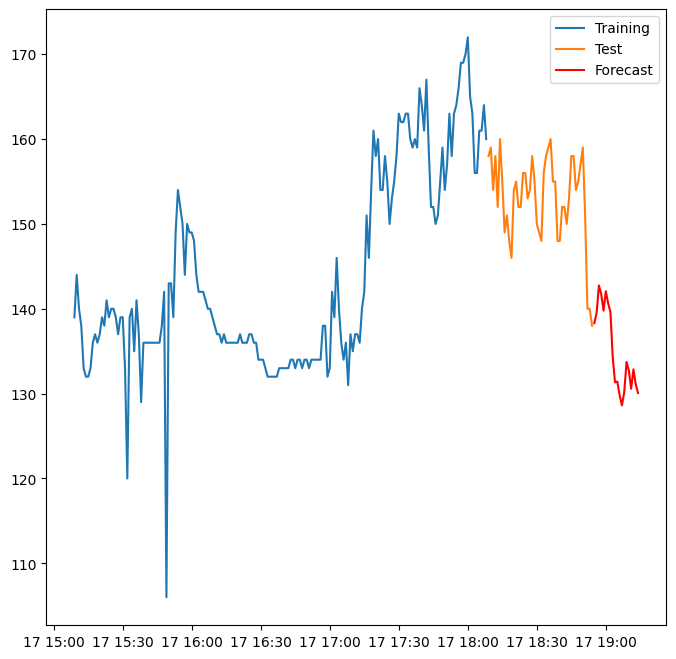

In [ ]:
# Plot observations and predictions
plt.figure(figsize=(8, 8))
plt.plot(train_series['Lifetouch Heart Rate'], label='Training')
plt.plot(eval_series['Lifetouch Heart Rate'], label='Test')
plt.plot(forecast_values_SRIMA, color='red', label='Forecast')
plt.legend()
plt.show()

#Conclusion


|Model | Mean Squared Error(MSE)  | Root Mean Squared Error(RMSE)| p = d = q |  
|------|---------------|------------| ------------|
|AutoRegressive Integrated Moving Average(ARIMA)    | 15.9609   | 3.9951 | (1,0,0) |
|Seasonal AutoRegressive Integrated Moving Average(SARIMA) | 17.1223 | 4.137 |  (0,2,2) |


These metrics provide insights into the accuracy of the models in predicting the time series data.

A lower RMSE value signifies better accuracy in predictions. In this comparison, ARIMA outperforms SARIMA with a lower RMSE (3.9951) compared to SARIMA's RMSE (4.137). Therefore, based on the RMSE criterion, ARIMA is considered the more effective model for this specific time series prediction task.

Additional, the forcasting grapgh of SARIMA model is more relaistic compare to ARIMA model because it uses exponenial smoothing for forcasting. Which shows that in forcasting this model SARIMA is more effective.

Conclusively, ARIMA is the best model for prediction and SARIMA is best model for forcasting.

# Submission

We have successfully generated predictions for the upcoming 20 minutes. In this section the prdiction is converted to CSV format.

In [54]:
# Creating a DataFrame for submission with predicted values
submission = pd.DataFrame({'prediction': forecast_values.values})

In [55]:
submission.head()

,prediction
0,138.742964
1,139.407651
2,140.002310
3,140.534316
4,141.010273


In [58]:
# Created by Hansi at 12/16/2022

import json

data = []
for pred in forecast_values:
    data.append({'prediction': pred})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))

[{'prediction': 138.74296388343078}, {'prediction': 139.40765142082296}, {'prediction': 140.0023095626486}, {'prediction': 140.53431638652694}, {'prediction': 141.01027263894477}]
